In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Embedding, Dropout, add, concatenate

In [24]:
BASE_DIR = '/kaggle/input/flickr8vr1/Flickr8K'
WORKING_DIR = '/kaggle/working'

In [25]:
#load vgg16 model
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [26]:
# extarct the feature from the image
# we store test features and train features seperately.
train_features = {}
test_features = {}
tr_directory = os.path.join(BASE_DIR, 'Flickr8k_text/Flickr_8k.trainImages.txt')
te_directory = os.path.join(BASE_DIR, 'Flickr8k_text/Flickr_8k.testImages.txt')
directory = os.path.join(BASE_DIR, 'Flicker8k_Images')

with open(tr_directory) as f:
    tr_img_names = f.readlines()
tr_img_names = [x.strip() for x in tr_img_names]

with open(te_directory) as g:
    te_img_names = g.readlines() 
te_img_names = [x.strip() for x in te_img_names]

for img_name in tqdm(tr_img_names):
    # load the image file
    img_path = directory  + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    # converts image pixels to numpy array
    image = img_to_array(image)
    #image reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    # store feature
    train_features[image_id]=feature
    
for img_name in tqdm(te_img_names):
    # load the image file
    img_path = directory  + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    # converts image pixels to numpy array
    image = img_to_array(image)
    #image reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    # store feature
    test_features[image_id]=feature

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# #store features in pickle
# pickle.dump(train_features, open(os.path.join(WORKING_DIR, 'tr_features.pkl'), 'wb'))
# pickle.dump(test_features, open(os.path.join(WORKING_DIR, 'te_features.pkl'), 'wb'))

In [ ]:
# #load features from pickle
# with open(os.path.join('/kaggle/input/firstall/tr_features.pkl'), 'rb') as f:
#     train_features = pickle.load(f)
    
# with open(os.path.join('/kaggle/input/firstall/te_features.pkl'), 'rb') as f:
#     test_features = pickle.load(f)

In [27]:
#load caption 
with open(os.path.join(BASE_DIR, 'Flickr8k_text/Flickr8k.token.txt'),'r') as f:
    captions_doc = f.read()

In [28]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by tab
    tokens = line.split('\t')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [29]:
# preprocess caption function
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # tkae one captin at a time
            caption = captions[i]
            # preprocessing text
            # convert to lower case
            caption = caption.lower()
            # delete digits and special characters etc.,
            caption = caption.replace('[A=Za-z]','')
            # delete addtional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1])  + ' endseq'
            captions[i]= caption

In [30]:
# Before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [31]:
# preprocess the text
clean(mapping)

In [32]:
# After preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [33]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [34]:
len(all_captions)

40460

In [35]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [36]:
vocab_size

8485

In [37]:
# get maximum length of the captions avilable
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [39]:
# craete data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y =list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n +=1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into X, Y pairs
                for i in range(1, len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seqence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:

# #Attention
# #Define input layers
# inputs1 = Input(shape=(2048,))
# inputs2 = Input(shape=(max_length,))

# # Define the feature extractor network
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(200, activation='relu')(fe1)
# fe3 = Reshape((1, 200), input_shape=(200,))(fe2)

# # Define the sequence encoder network with attention
# se1 = Embedding(vocab_size, 200, mask_zero=False)(inputs2)
# se2 = LSTM(200, return_sequences=True)(se1)
# attn = Attention()([fe3, se2])
# context = concatenate([attn, fe3], axis=-1)
# se3 = LSTM(200)(context)
# se4 = Dropout(0.5)(se3)
# in1 = Input(shape = (1, 2048))

# feat_l1 = Dropout(0.5)(in1)
# feat_l2 = Dense(emb_dim, activation = 'relu')(feat_l1)

# # sequence input -> second path
# in2 = Input(shape=(caption_max_length,))
# emb = Embedding(vocab_size, 
# , weights=[embedding_matrix], trainable=False, mask_zero=False)(in2)
# emb = Dense(emb_dim, activation = 'relu')(emb)

# comb_l1 = concatenate([feat_l2, emb], axis = 1)
# query = Dense(emb_dim, activation = 'relu')(comb_l1)
# value = Dense(emb_dim, activation = 'relu')(comb_l1)
# key = Dense(emb_dim, activation = 'relu')(comb_l1)
# atte_layer1 = Attention()([query, value, key])

# seq_l1 = Dropout(0.1)(atte_layer1)
# seq_l2 = LSTM(emb_dim, return_sequences = True)(seq_l1)

# seq_l3 = Dropout(0.1)(seq_l2)
# seq_l4 = LSTM(emb_dim, return_sequences = True)(seq_l3)

# seq_l5 = Dropout(0.1)(seq_l4)
# seq_l6 = LSTM(emb_dim)(seq_l5)


# comb_l2 = add([Reshape((emb_dim, ))(feat_l2), seq_l6])
# comb_l3 = Dense(emb_dim, activation = 'relu')(comb_l2)

# # Define the decoder network
# decoder1 = add([fe2, se4])
# decoder2 = Dense(200, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # Define the model
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.summary()

In [ ]:
# # MultiHead Attention
# # Define input layers
# inputs1 = Input(shape=(2048,))
# inputs2 = Input(shape=(max_length,))

# # Define the feature extractor network
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(200, activation='relu')(fe1)
# fe3 = Reshape((1, 200), input_shape=(200,))(fe2)

# # Define the sequence encoder network with attention
# se1 = Embedding(vocab_size, 200, mask_zero=False)(inputs2)
# se2 = LSTM(200, return_sequences=True)(se1)
# attn = MultiHeadAttention(num_heads=8, key_dim=4)(fe3, se2)
# context = concatenate([attn, fe3], axis=-1)
# se3 = LSTM(200)(context)
# se4 = Dropout(0.5)(se3)

# # Define the decoder network
# decoder1 = add([fe2, se4])
# decoder2 = Dense(200, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# # Define the model
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.summary()

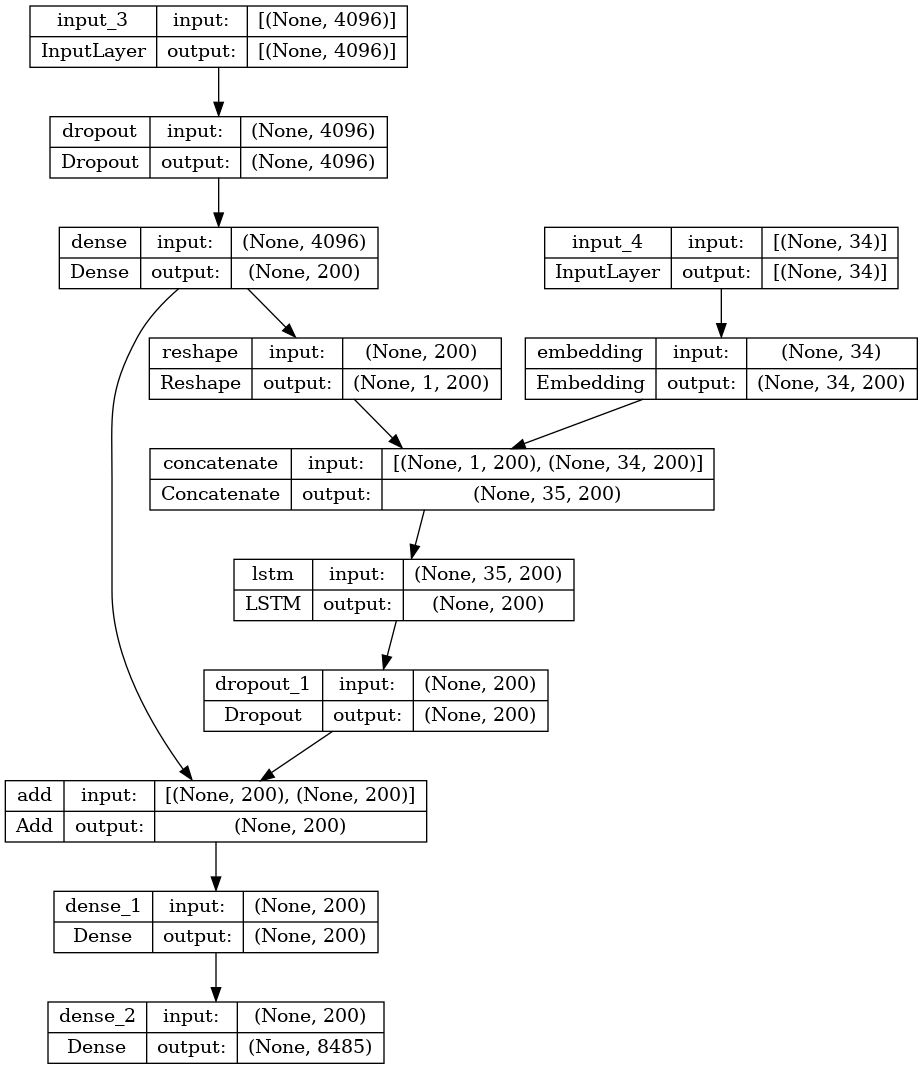

In [21]:
inputs1 = Input(shape=(4096,))
inputs2 = Input(shape=(max_length,))

fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(200, activation='relu')(fe1)
fe3 = Reshape((1, 200), input_shape=(200,))(fe2)

se1 = Embedding(vocab_size, 200, mask_zero=False)(inputs2)
merged = concatenate([fe3, se1], axis = 1)
se2 = LSTM(200)(merged)
se3 = Dropout(0.5)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(200, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)

In [ ]:
tr_img_names = [x.split('.')[0] for x in tr_img_names]
te_img_names = [x.split('.')[0] for x in te_img_names]

In [ ]:
# train the model
epochs = 15
batch_size = 64
steps = len(tr_img_names) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(tr_img_names, mapping, train_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# # save the model
# from tensorflow import keras
# model = keras.models.load_model('/kaggle/input/firstall/first_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generaation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequences
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text+=" "+word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(te_img_names):
    #get actual caption
    captions= mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, test_features[key], tokenizer, max_length)
    #split ino words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU score
print("BLEU-1:%f"% corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2:%f"% corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))
print("BLEU-3:%f"% corpus_bleu(actual, predicted, weights=(1/3,1/3,1/3,0)))
print("BLEU-4:%f"% corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #image_name = ""
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Flicker8k_Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-------------Actual------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, train_features[image_id], tokenizer, max_length)
    print('--------------Predicted---------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")